# Imbalanced data

In [ ]:
#code adapted from https://github.com/thomasjpfan/ml-workshop-advanced

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [12, 8]

sklearn.set_config(display='diagram')

## Load Mammography Data

In [9]:
# %load solutions/classifier_example.py
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/davidrkearney/colab-notebooks/main/datasets/strokes_training.csv'
df = pd.read_csv(url, error_bad_lines=False)
df

df=df.dropna()

df.isnull().sum()

df.columns

sklearn.set_config(display='diagram')

X, y = df.drop(['stroke', 'id'], axis = 1), df['stroke']


X = X.select_dtypes(include='number')
X

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

rf.score(X_test, y_test)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      7139
           1       0.17      0.01      0.01       129

    accuracy                           0.98      7268
   macro avg       0.57      0.50      0.50      7268
weighted avg       0.97      0.98      0.97      7268



In [10]:
from sklearn.datasets import fetch_openml

In [13]:
np.bincount(y)

array([28524,   548])

## Split data into train test split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0)

### Base models
#### Linear model

In [15]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

In [20]:
base_log_reg = LogisticRegression(random_state=42)
cv_results = cross_validate(base_log_reg,
                            X_train, y_train, scoring=['roc_auc', 'average_precision'])

In [21]:
cv_results

{'fit_time': array([0.18456721, 0.18922424, 0.21849942, 0.16009235, 0.14718604]),
 'score_time': array([0.02156591, 0.01044083, 0.00906014, 0.00876856, 0.00877857]),
 'test_roc_auc': array([0.85926447, 0.82782335, 0.83645313, 0.82829213, 0.82486117]),
 'test_average_precision': array([0.08657556, 0.08525184, 0.10518971, 0.0796069 , 0.08259916])}

In [22]:
log_reg_base_auc = cv_results['test_roc_auc'].mean()
log_reg_base_auc

0.8353388498771366

In [25]:
log_reg_base_ap = cv_results['test_average_precision'].mean()
log_reg_base_ap

0.08784463474925555

In [26]:
def compute_metrics(estimator):
    cv_results = cross_validate(estimator,
                                X_train, y_train, scoring=['roc_auc', 'average_precision'])
    return {
        "auc": cv_results["test_roc_auc"].mean(),
        "average_precision": cv_results["test_average_precision"].mean(),
    }

In [27]:
base_log_reg_metrics = compute_metrics(base_log_reg)
base_log_reg_metrics

{'auc': 0.8353388498771366, 'average_precision': 0.08784463474925555}

#### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
base_rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [30]:
base_rf_metrics = compute_metrics(base_rf)
base_rf_metrics

{'auc': 0.7132260944197908, 'average_precision': 0.04824294956894796}

### Imbalance-learn sampler

#### Under sampler

In [31]:
np.bincount(y_train)

array([21393,   411])

In [32]:
from imblearn.under_sampling import RandomUnderSampler

In [33]:
under_sampler = RandomUnderSampler(random_state=42)

In [34]:
X_train_subsample, y_train_subsample = under_sampler.fit_resample(X_train, y_train)

In [35]:
X_train.shape

(21804, 5)

In [36]:
X_train_subsample.shape

(822, 5)

In [37]:
np.bincount(y_train_subsample)

array([411, 411])

#### Oversampling

In [38]:
from imblearn.over_sampling import RandomOverSampler

In [39]:
over_sampler = RandomOverSampler(random_state=42)

In [40]:
X_train_subsample, y_train_subsample = over_sampler.fit_resample(X_train, y_train)

In [41]:
X_train_subsample.shape

(42786, 5)

In [42]:
np.bincount(y_train_subsample)

array([21393, 21393])

## Pipelines with imblean

### Linear model with under sampling

In [43]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

In [44]:
under_log_reg = make_imb_pipeline(
    RandomUnderSampler(random_state=42), LogisticRegression(random_state=42))

In [45]:
base_log_reg_metrics

{'auc': 0.8353388498771366, 'average_precision': 0.08784463474925555}

In [46]:
compute_metrics(under_log_reg)

{'auc': 0.8347615373366913, 'average_precision': 0.08779628352835236}

### Random Forest with under sampling

In [47]:
under_rf = make_imb_pipeline(
    RandomUnderSampler(random_state=42), RandomForestClassifier(random_state=42))

In [48]:
base_rf_metrics

{'auc': 0.7132260944197908, 'average_precision': 0.04824294956894796}

In [49]:
compute_metrics(under_rf)

{'auc': 0.7930356061088476, 'average_precision': 0.0634524323793531}

### Linear model with over sampling

In [50]:
over_log_reg = make_imb_pipeline(
    RandomOverSampler(), LogisticRegression(random_state=42))

In [51]:
base_log_reg_metrics

{'auc': 0.8353388498771366, 'average_precision': 0.08784463474925555}

In [52]:
compute_metrics(over_log_reg)

{'auc': 0.835413689744715, 'average_precision': 0.08676060348173371}

## Exercise 1

1. Use `make_imb_pipeline` with `RandomOverSampler` to create a pipline with random forset called `over_rf`.
1. Compute our metrics using `compute_metrics`.

In [64]:
# %load solutions/02-ex01-solutions.py
over_rf = make_imb_pipeline(
    RandomOverSampler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

base_rf_metrics

compute_metrics(over_rf)

{'auc': 0.713025487676646, 'average_precision': 0.04324731383558929}

## Plotting curves for logistic regression

In [54]:
base_log_reg.fit(X_train, y_train)
under_log_reg.fit(X_train, y_train)
over_log_reg.fit(X_train, y_train);

In [55]:
base_log_reg.score(X_test, y_test)

0.9811502476609797

### Plotting

In [56]:
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

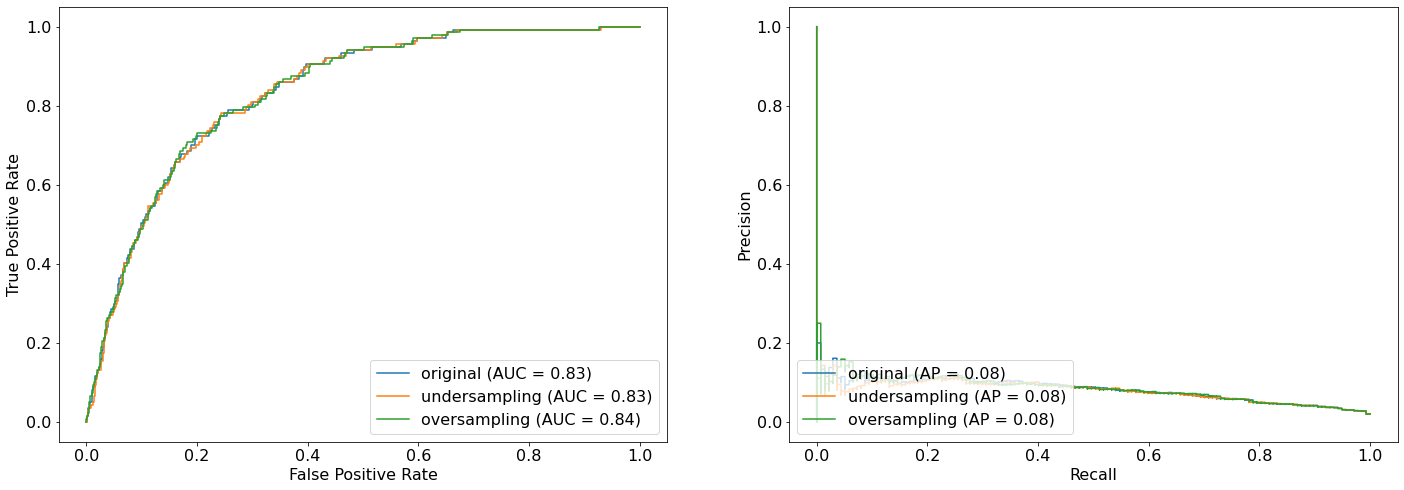

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
plot_roc_curve(base_log_reg, X_test, y_test, ax=ax1, name="original")
plot_roc_curve(under_log_reg, X_test, y_test, ax=ax1, name="undersampling")
plot_roc_curve(over_log_reg, X_test, y_test, ax=ax1, name="oversampling")

plot_precision_recall_curve(base_log_reg, X_test, y_test, ax=ax2, name="original")
plot_precision_recall_curve(under_log_reg, X_test, y_test, ax=ax2, name="undersampling")
plot_precision_recall_curve(over_log_reg, X_test, y_test, ax=ax2, name="oversampling");

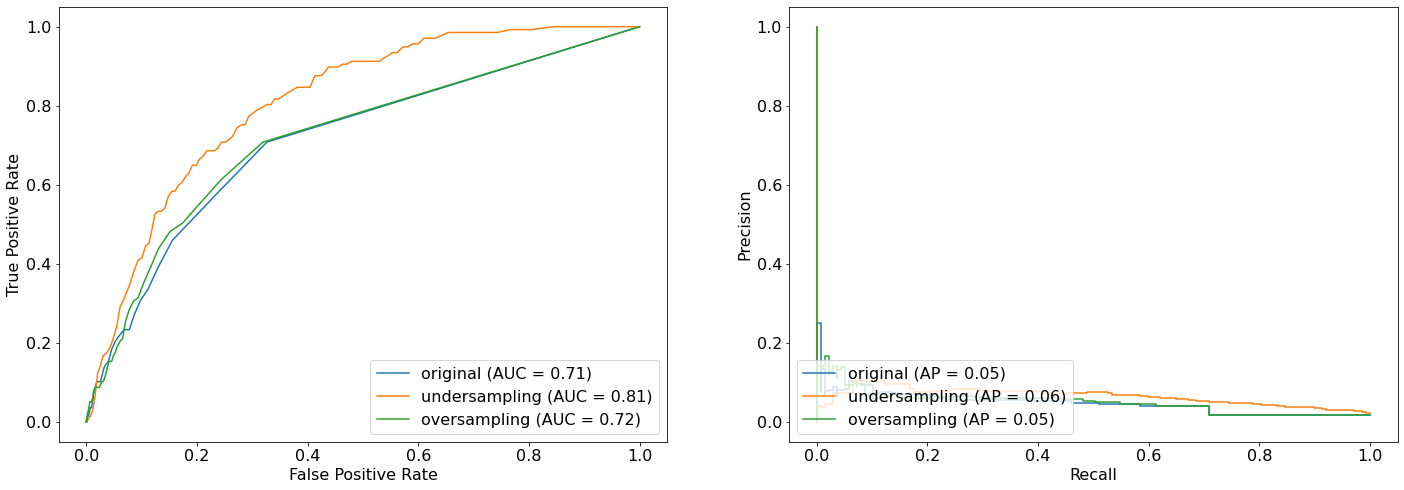

In [67]:
# %load solutions/02-ex02-solutions.py
base_rf.fit(X_train, y_train)
under_rf.fit(X_train, y_train)
over_rf.fit(X_train, y_train);

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
plot_roc_curve(base_rf, X_test, y_test, ax=ax1, name="original")
plot_roc_curve(under_rf, X_test, y_test, ax=ax1, name="undersampling")
plot_roc_curve(over_rf, X_test, y_test, ax=ax1, name="oversampling")

plot_precision_recall_curve(base_rf, X_test, y_test, ax=ax2, name="original")
plot_precision_recall_curve(under_rf, X_test, y_test, ax=ax2, name="undersampling")
plot_precision_recall_curve(over_rf, X_test, y_test, ax=ax2, name="oversampling");

## Class-Weights

#### Linear model with class weights

In [59]:
class_weight_log_reg = LogisticRegression(class_weight='balanced', random_state=42)
class_weight_log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

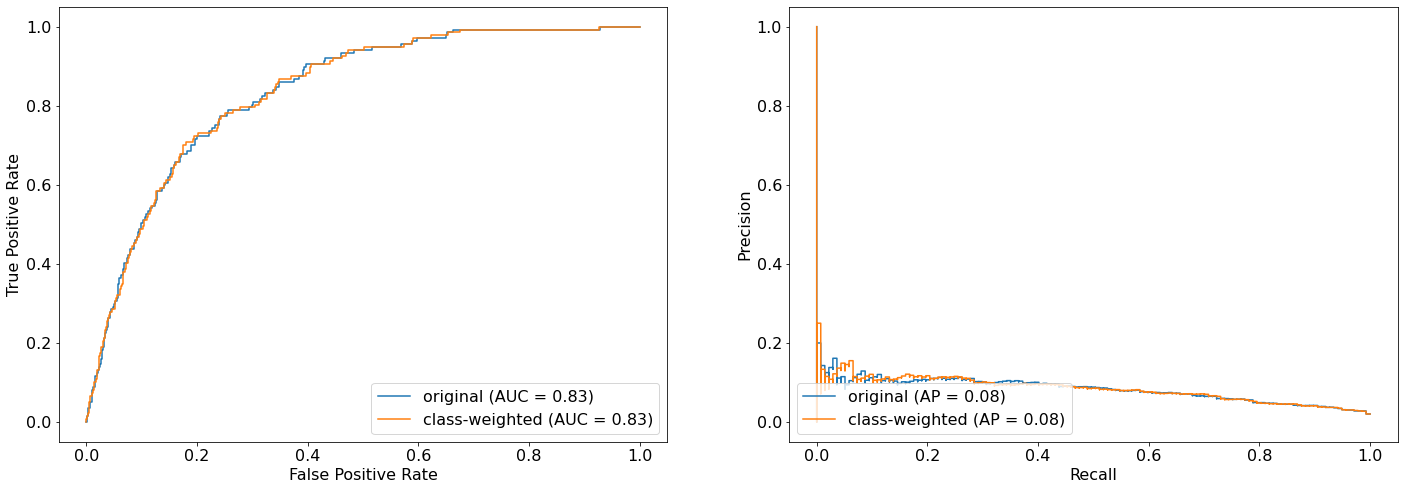

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
plot_roc_curve(base_log_reg, X_test, y_test, ax=ax1, name="original")
plot_roc_curve(class_weight_log_reg, X_test, y_test, ax=ax1, name="class-weighted")

plot_precision_recall_curve(base_log_reg, X_test, y_test, ax=ax2, name="original")
plot_precision_recall_curve(class_weight_log_reg, X_test, y_test, ax=ax2, name="class-weighted")

#### Random forest with class weights 

In [68]:
class_weight_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
class_weight_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

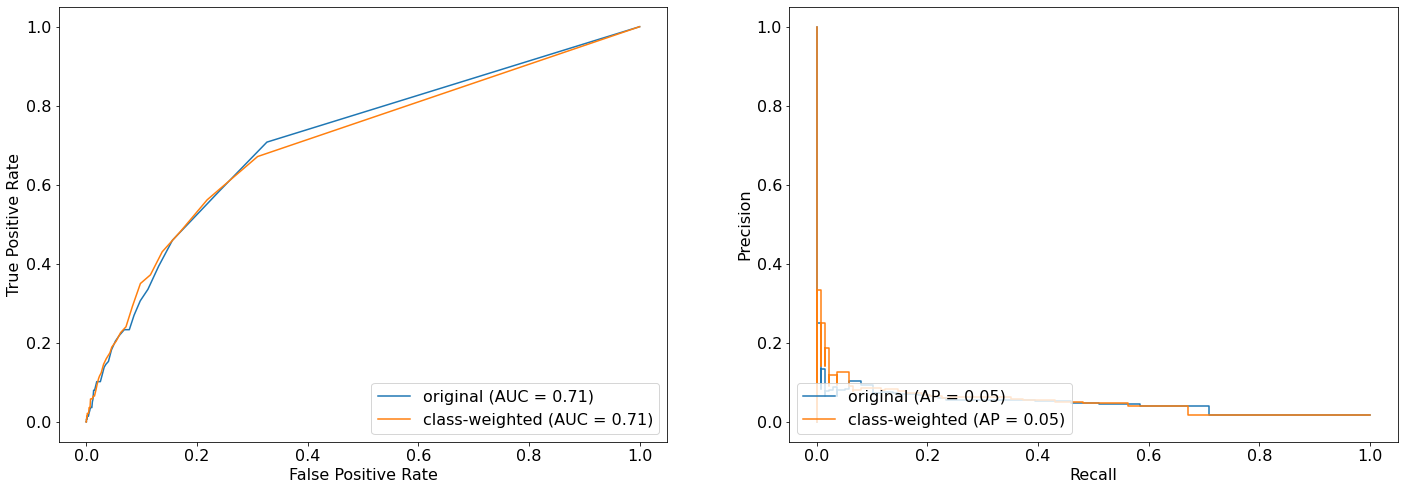

In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
plot_roc_curve(base_rf, X_test, y_test, ax=ax1, name="original")
plot_roc_curve(class_weight_rf, X_test, y_test, ax=ax1, name="class-weighted")

plot_precision_recall_curve(base_rf, X_test, y_test, ax=ax2, name="original")
plot_precision_recall_curve(class_weight_rf, X_test, y_test, ax=ax2, name="class-weighted")

## Ensemble Resampling

In [70]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [71]:
balanced_rf = BalancedRandomForestClassifier(random_state=0)
balanced_rf.fit(X_train, y_train)

BalancedRandomForestClassifier(random_state=0)

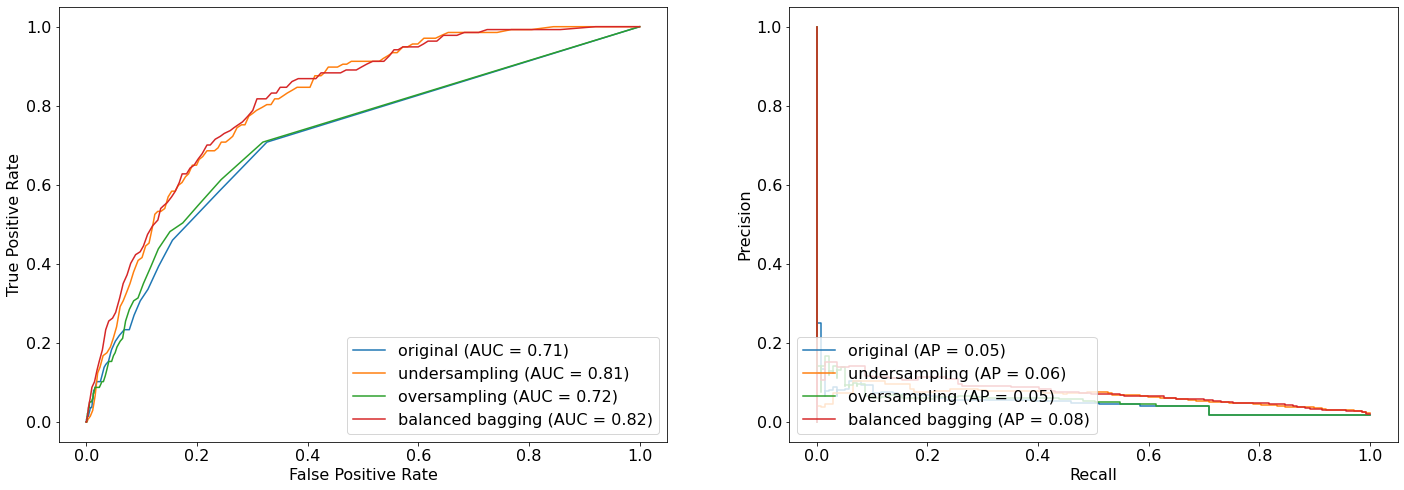

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
plot_roc_curve(base_rf, X_test, y_test, ax=ax1, name="original")
plot_roc_curve(under_rf, X_test, y_test, ax=ax1, name="undersampling")
plot_roc_curve(over_rf, X_test, y_test, ax=ax1, name="oversampling")
plot_roc_curve(balanced_rf, X_test, y_test, ax=ax1, name="balanced bagging")

plot_precision_recall_curve(base_rf, X_test, y_test, ax=ax2, name="original")
plot_precision_recall_curve(under_rf, X_test, y_test, ax=ax2, name="undersampling")
plot_precision_recall_curve(over_rf, X_test, y_test, ax=ax2, name="oversampling");
plot_precision_recall_curve(balanced_rf, X_test, y_test, ax=ax2, name="balanced bagging")

## SMOTE

In [73]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_smote.shape

(42786, 5)

In [74]:
np.bincount(y_train_smote)

array([21393, 21393])

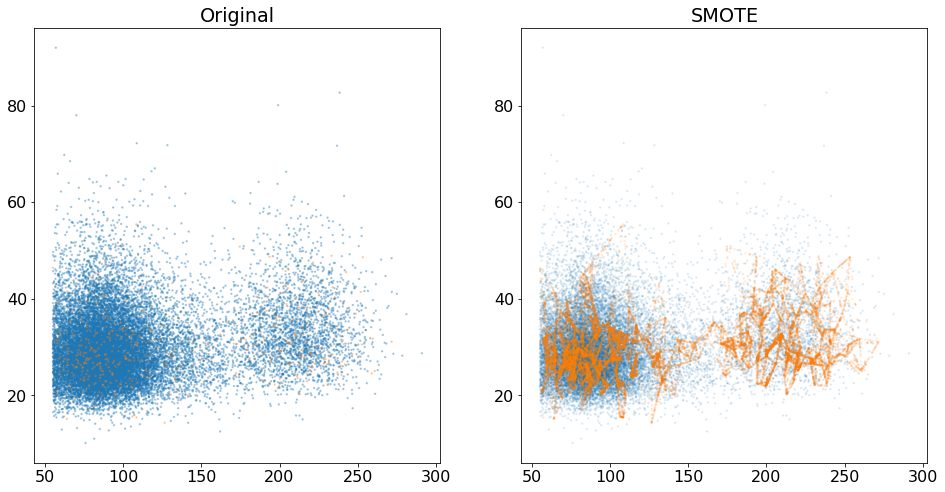

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sorting = np.argsort(y_train)

axes[0].set_title("Original")
axes[0].scatter(X_train.iloc[sorting, 3], X_train.iloc[sorting, 4], c=plt.cm.tab10(y_train.iloc[sorting]), alpha=.3, s=2)

axes[1].set_title("SMOTE")
axes[1].scatter(X_train_smote.iloc[:, 3], X_train_smote.iloc[:, 4], c=plt.cm.tab10(y_train_smote), alpha=.1, s=2)

In [78]:
cv_results

{'fit_time': array([0.18456721, 0.18922424, 0.21849942, 0.16009235, 0.14718604]),
 'score_time': array([0.02156591, 0.01044083, 0.00906014, 0.00876856, 0.00877857]),
 'test_roc_auc': array([0.85926447, 0.82782335, 0.83645313, 0.82829213, 0.82486117]),
 'test_average_precision': array([0.08657556, 0.08525184, 0.10518971, 0.0796069 , 0.08259916])}

In [80]:
smote_log_reg = make_imb_pipeline(
    SMOTE(random_state=42), LogisticRegression(random_state=42))
compute_metrics(smote_log_reg)

{'auc': 0.7872750489175167, 'average_precision': 0.06044681160292857}

In [81]:
base_rf_metrics

{'auc': 0.7132260944197908, 'average_precision': 0.04824294956894796}

In [82]:
smote_rf = make_imb_pipeline(SMOTE(random_state=42), RandomForestClassifier(random_state=42, n_jobs=-1))
compute_metrics(smote_rf)

{'auc': 0.7160674179833459, 'average_precision': 0.03946048645139655}

## Plotting all the version of random forest

In [83]:
smote_rf.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

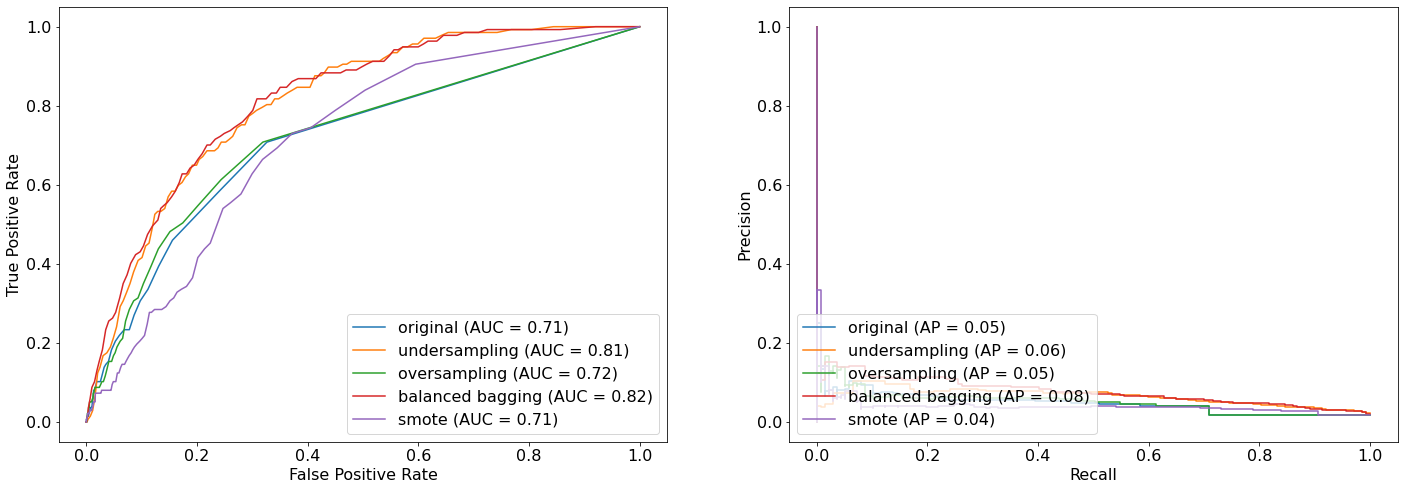

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
plot_roc_curve(base_rf, X_test, y_test, ax=ax1, name="original")
plot_roc_curve(under_rf, X_test, y_test, ax=ax1, name="undersampling")
plot_roc_curve(over_rf, X_test, y_test, ax=ax1, name="oversampling")
plot_roc_curve(balanced_rf, X_test, y_test, ax=ax1, name="balanced bagging")
plot_roc_curve(smote_rf, X_test, y_test, ax=ax1, name="smote")

plot_precision_recall_curve(base_rf, X_test, y_test, ax=ax2, name="original")
plot_precision_recall_curve(under_rf, X_test, y_test, ax=ax2, name="undersampling")
plot_precision_recall_curve(over_rf, X_test, y_test, ax=ax2, name="oversampling");
plot_precision_recall_curve(balanced_rf, X_test, y_test, ax=ax2, name="balanced bagging")
plot_precision_recall_curve(smote_rf, X_test, y_test, ax=ax2, name="smote")

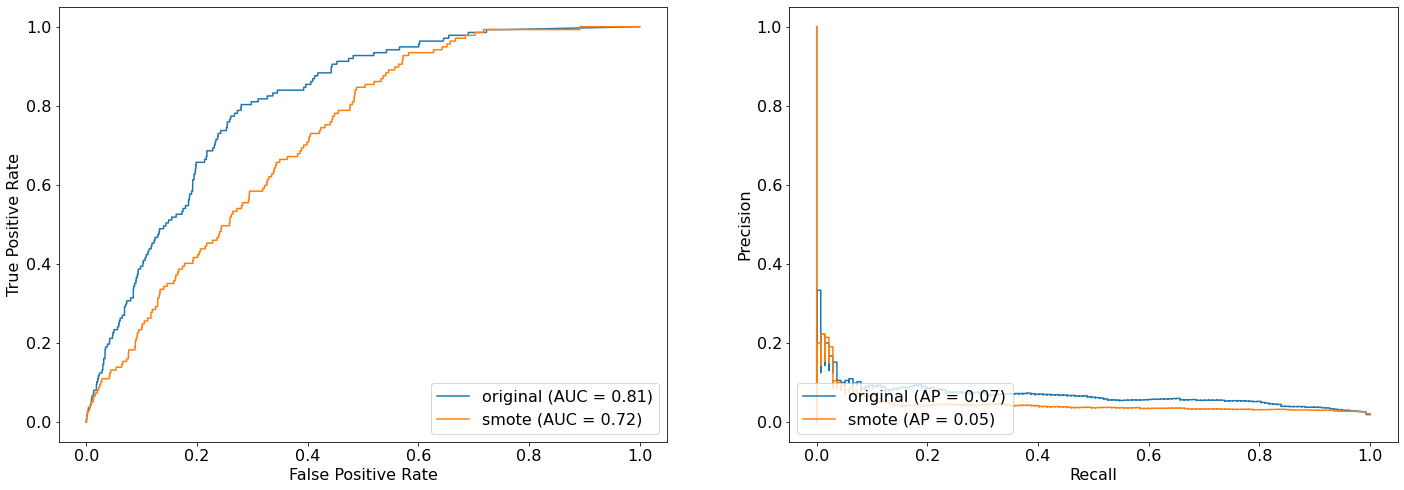

In [87]:
# %load solutions/02-ex03-solutions.py
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

base_hist = HistGradientBoostingClassifier(random_state=42)
base_hist.fit(X_train, y_train)

smote_hist = make_imb_pipeline(
    SMOTE(), HistGradientBoostingClassifier(random_state=42))
smote_hist.fit(X_train, y_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8))
plot_roc_curve(base_hist, X_test, y_test, ax=ax1, name="original")
plot_roc_curve(smote_hist, X_test, y_test, ax=ax1, name="smote")

plot_precision_recall_curve(base_hist, X_test, y_test, ax=ax2, name="original")
plot_precision_recall_curve(smote_hist, X_test, y_test, ax=ax2, name="smote")
